# Analiza zbioru

Zbiór został zapisany w formacie JSON, wstępnie podzielone na zbiór treningowy oraz testowy.

In [1]:
import json

base_path = '../../../data/fewrel'
train_file, test_file = f'{base_path}/fewrel_train.json', f'{base_path}/fewrel_val.json'
with open(train_file) as fp:
    train_json = json.load(fp)
with open(test_file) as fp:
    test_json = json.load(fp)

## Klucze

`P<liczba>` oznacza identyfikator relacji w WikiDacie. Do każdej relacji przypisane są zbiory dokumentów w których występuje co najmniej raz dana relacja.

In [ ]:
train_json.keys()

Każdy zbiór danych zawiera własną listę kluczy, ponieważ zadanie `fewrel` było dedykowane `few-shot learning`. Można to wykorzystać w tym zadaniu lub wybrać/połączyć zbiór/zbiory w celu stworzenia jednego dla innych metod.

In [ ]:
train_uniq = set(train_json.keys()) - set(test_json.keys())
f'Klucze przed: {len(train_json)=}, klucze unikalne: {len(train_uniq)=}'

'Klucze przed: len(train_json)=64, klucze unikalne: len(train_uniq)=64'

In [ ]:
test_uniq = set(test_json.keys()) - set(train_json.keys())
f'Klucze przed: {len(test_json)=}, klucze unikalne: {len(test_uniq)=}'

'Klucze przed: len(test_json)=16, klucze unikalne: len(test_uniq)=16'

## Wartości

Dokumenty zostały już wstępnie stokenizowane. Pierwszy i drugi argument relacji są oznaczone odpowiednio jako `h` i `t`. `Q<numer>` oznacza identyfikator encji w WikiDacie. Lista zawiera kolejne wystąpienia encji. Liczby w podwójnej liście oznaczają zakres `od-do` encji w dokumencie stokenizowanym.

In [ ]:
train_json['P931']

## Zbiór treningowy

Relacje w zbiorze treningowym.

In [2]:
train_json.keys()

dict_keys(['P931', 'P4552', 'P140', 'P1923', 'P150', 'P6', 'P27', 'P449', 'P1435', 'P175', 'P1344', 'P39', 'P527', 'P740', 'P706', 'P84', 'P495', 'P123', 'P57', 'P22', 'P178', 'P241', 'P403', 'P1411', 'P135', 'P991', 'P156', 'P176', 'P31', 'P1877', 'P102', 'P1408', 'P159', 'P3373', 'P1303', 'P17', 'P106', 'P551', 'P937', 'P355', 'P710', 'P137', 'P674', 'P466', 'P136', 'P306', 'P127', 'P400', 'P974', 'P1346', 'P460', 'P86', 'P118', 'P264', 'P750', 'P58', 'P3450', 'P105', 'P276', 'P101', 'P407', 'P1001', 'P800', 'P131'])

Semantyczne znaczenie relacji.

In [ ]:
from bs4 import BeautifulSoup
from requests import request
import pandas as pd

def get_semantics_details(dataset: dict) -> pd.DataFrame:
    links = {k: f'https://www.wikidata.org/wiki/Property:{k}' for k in dataset.keys()}
    responses = {k: request('GET', l).content for k, l in links.items()}
    keys_titles = {k: BeautifulSoup(r, 'lxml').title.text for k, r in responses.items()}
    keys_titles = {k: v.replace(' - Wikidata', '') for k, v in keys_titles.items()}

    sem_details = pd.DataFrame({'rel': keys_titles.keys(), 'val': keys_titles.values()})
    return sem_details

get_semantics_details(train_json)

Ilość relacji w zbiorze.

In [ ]:
len(train_json)

## Zbiór testowy.

Relacje w zbiorze testowym.

In [ ]:
test_json.keys()

Semantyczne znaczenie relacji.

In [ ]:
get_semantics_details(test_json)

Ilość relacji.

In [ ]:
len(test_json)

## Badanie zbalansowania danych

W zbiorze treningowym dane są zbalansowane, jednak relacje `P178`, `P136`, `P306` występuje zbyt często, powyżej `2σ`.

<AxesSubplot:>

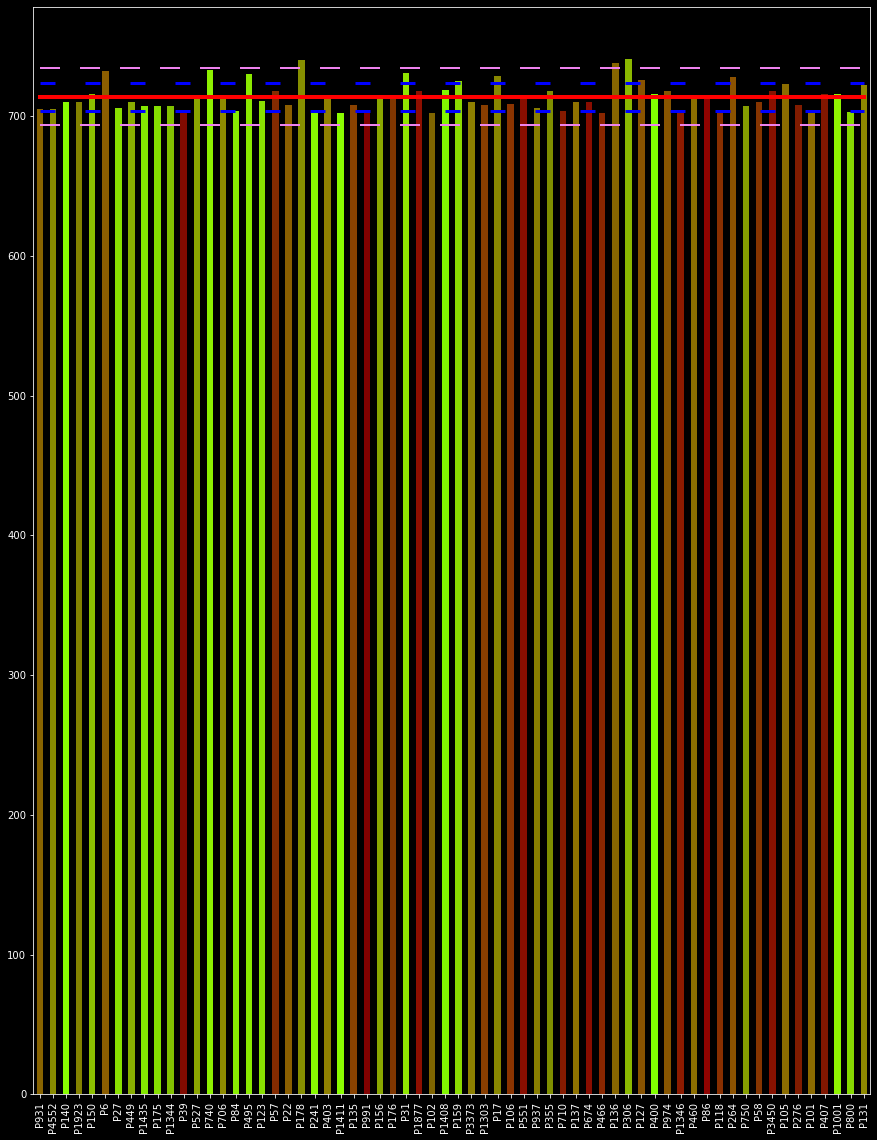

In [4]:
import random
import matplotlib.pyplot as plt
from itertools import repeat
import pandas as pd


def show_dist(dataset: dict):
    x = pd.Series({
        rel: sum(len(doc['h'][2]) for doc in corpus) 
        for rel, corpus in dataset.items()
    })

    colors = [
        f'#8{h_num[2:]:0<5}' 
        for _ in range(len(x)) 
        if (h_num := hex(random.randint(0, 16**5))[2:] )
    ]

    mean = x.mean()
    upper, lower = (x.mean() + x.std(), x.mean() - x.std())
    double_upper, double_lower = (upper + x.std(), lower - x.std())

    plt.plot(list(repeat(double_upper, len(x))), color='violet', linestyle='dashed', linewidth=2, dashes=(10,10))
    plt.plot(list(repeat(upper, len(x))), color='blue', linestyle='dashed', linewidth=3, dashes=(5,10))
    plt.plot(list(repeat(mean, len(x))), color='red', linewidth=4)
    plt.plot(list(repeat(lower, len(x))), color='blue', linestyle='dashed', linewidth=3, dashes=(5,10))
    plt.plot(list(repeat(double_lower, len(x))), color='violet', linestyle='dashed', linewidth=2, dashes=(10,10))

    return x\
        .plot\
        .bar(figsize=(15,20), color=colors)

show_dist(train_json)

W zbiorze testowym dane są zbalansowane, jednak relacja `P59` występuje zbyt często, powyżej `2σ`.

<AxesSubplot:>

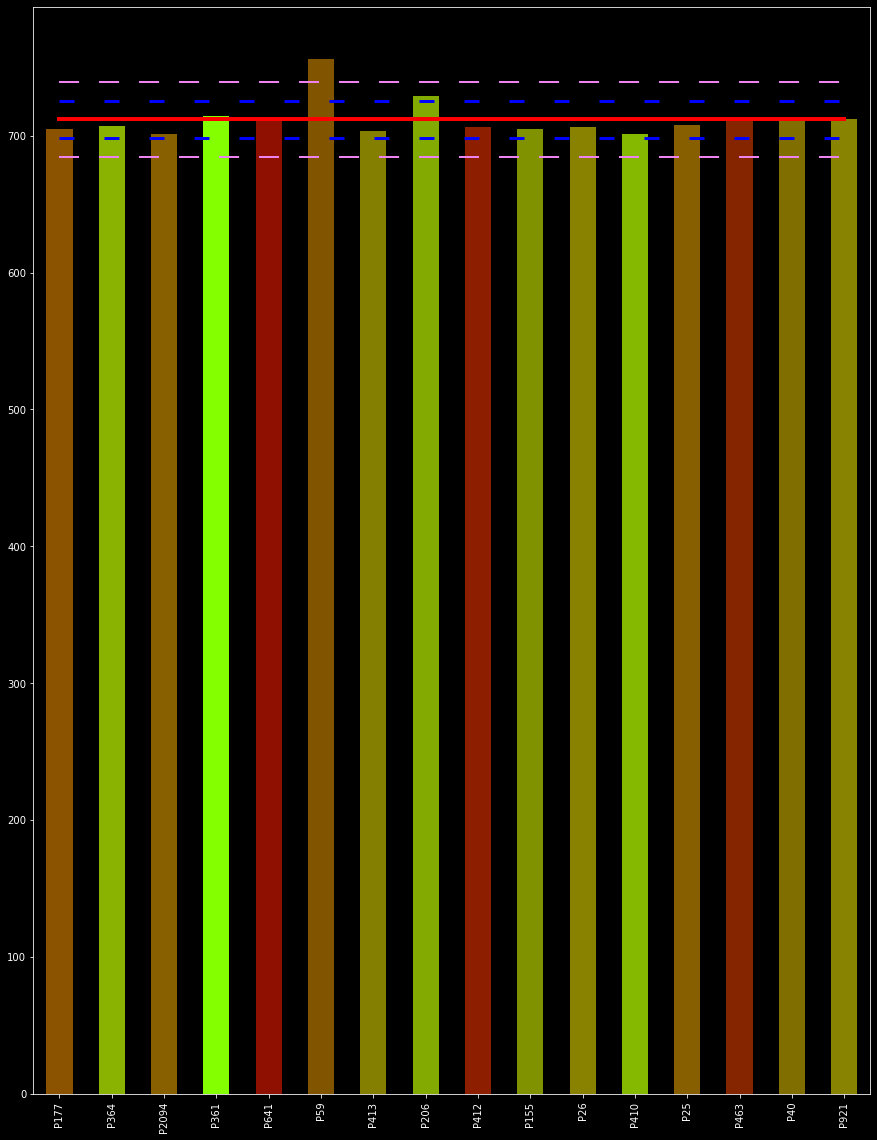

In [5]:
show_dist(test_json)

Oba zbiory posiadają ~ jednakową liczność relacji, zatem można je połaczyć w jeden zbiór dla pozostałych metod.

# Przetwarzanie zbioru

# Translacja

## Oznaczenie encji w tekście

In [ ]:
from tqdm.notebook import tqdm

def preprocessing(dataset: dict) -> dict:
    dataset = dataset.copy()
    for rel_docs in tqdm(dataset.values()):
        for doc in rel_docs:
            tokens = doc['tokens']
            h_pos = doc['h'][2]
            t_pos = doc['t'][2]

            for h_id, pos in enumerate(h_pos):
                start, stop = pos[0], pos[-1]
                tokens[start] = f'<h{h_id}>{tokens[start]}'
                tokens[stop] = f'{tokens[stop]}</h{h_id}>'

            for t_id, pos in enumerate(t_pos):
                start, stop = pos[0], pos[-1]
                tokens[start] = rf'<t{t_id}>{tokens[start]}'
                tokens[stop] = rf'{tokens[stop]}</t{t_id}>'
    
    return dataset

preprocessed_train = preprocessing(train_json)
preprocessed_test = preprocessing(test_json)

## Prosty test

In [ ]:
from googletrans import Translator

translator = Translator()
txt = ' '.join(preprocessed_train['P27'][3]['tokens'])

txt, Translator().translate(txt, dest='pl').text

## Przetłumaczenie finalne

In [146]:
from googletrans import Translator
import random
from time import sleep

MIN_WAIT_S, MAX_WAIT_S = 0.1, 3
translator = Translator()

def translate_dataset(dataset: dict) -> dict:
    dataset = dataset.copy()
    for rel_docs in tqdm(dataset.values(), desc='json'):
        for doc in tqdm(rel_docs, desc='translation'):
            en_text = ' '.join(doc['tokens'])

            timeout = MIN_WAIT_S + random.random() * MAX_WAIT_S
            if random.random() > 0.95:
                sleep(timeout)

            while 1:
                try:
                    pl_text = translator.translate(en_text, src='en', dest='pl')
                    doc['pl_text'] = pl_text.text
                    break
                except:
                    timeout = MIN_WAIT_S + random.random() * MAX_WAIT_S
                    sleep(timeout)
                    continue
    
    return dataset

processed_train = translate_dataset(preprocessed_train)
processed_test = translate_dataset(preprocessed_test)

In [ ]:
import pandas as pd

def build_dataframe(translated_dataset: dict) -> pd.DataFrame:
    df = []

    for rel, rel_docs in translated_dataset.items():
        for doc in rel_docs:
            df.append({
                'rel': rel,
                'text': ' '.join(doc['tokens']),
                'text_pl': doc['pl_text']
            })

    df = pd.DataFrame(df)
    return df

processed_train = build_dataframe(processed_train)
processed_train

In [ ]:
processed_test = build_dataframe(processed_test)
processed_test

In [ ]:
processed_train.to_csv('fewrel_train.csv', index=False)
processed_test.to_csv('fewrel_test.csv', index=False)

# Postprocessing

Usuwamy błędnie przetłumaczone przykłady, przez błędne rozumiemy pomieszane znaczniki etykiety.

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm
import re

tqdm.pandas()

def postprocessing(name: str):

    df = pd.read_csv(name)
    begin = r'\<[th]\d+\>'
    end = r'\</[th]\d+\>'
    inner_text = rf'(?:(?!{begin}).)*'
    pattern_tag = re.compile(fr'({begin})({inner_text})({end})')

    ents_pl = df['text_pl'].progress_apply(pattern_tag.findall)
    ents_en = df['text'].progress_apply(pattern_tag.findall)

    df['valid'] = True

    for doc_index, (pl, en) in enumerate(zip(ents_pl, ents_en)):
        if len(pl) != len(en):
            df.loc[doc_index, 'valid'] = False
        else:
            for p in pl:
                tag_start = p[0]
                text = p[1]
                tag_end = p[2]

                tag_start_letter = tag_start[1]
                tag_start_number = tag_start[2:-1]
                tag_end_letter = tag_end[2]
                tag_end_number = tag_end[3:-1]

                if not(all([
                    tag_start_letter == tag_end_letter,
                    tag_start_number == tag_end_number
                ])):
                    df.loc[doc_index, 'valid'] = False

    print(df['valid'].value_counts(True))

    df[df['valid']]\
        .drop(columns=['valid'])\
        .to_csv(f'fix_{name}', index=False)

~ 3% przykładów zostało błędnie przetłumaczonych

In [ ]:
postprocessing('fewrel_test.csv')
postprocessing('fewrel_train.csv')